## 1. 리뷰내용 불러오기

In [1]:
import pandas as pd
import numpy as np
import pickle
from pprint import pprint
import re

In [2]:
import matplotlib # 글자 깨짐 방지 폰트설정
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False   
#그래프에서 마이너스 기호가 표시되도록 하는 설정입니다.

In [3]:
with open("D:/cleaned_data.pk", "rb") as f:
    data = pickle.load(f)

data.reset_index(drop=True, inplace=True)
print(data.head())
print(data.info())

         DATE  STAR                                             REVIEW  LIKE
0  2020-01-07     1          오류 자체 오류 이용 자수 결제 툭하면 점검 충전 체크카드 출금 충전 금액     0
1  2020-01-07     5                          국굿 아이폰 바코드 큐알 코드 결제 가능 최고     0
2  2020-01-07     3                           현상 사용 오늘 업데이트 접속 화면 바탕화면     0
3  2020-01-07     2        설치 아이폰 설치 아버지 설치 갤럭시 노트 부산 지역화폐 설치 사용 버전 설치     0
4  2020-01-07     4  개선 사항 요청 본인 인증 수단 공인 인증서 추가 어머니 발급 어머니 핸드폰 명의 ...     0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266 entries, 0 to 2265
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    2266 non-null   object
 1   STAR    2266 non-null   int64 
 2   REVIEW  2266 non-null   object
 3   LIKE    2266 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 70.9+ KB
None


## 2. 분석시기 설정하기

In [4]:
##Date column을 pandas.Datetime으로 변환
data['DATE'] = pd.to_datetime(data['DATE'])
# Date column을 index로 설정
data = data.set_index("DATE")

In [5]:
## 4월을 기준으로 나누기
before_4 = data['2019-12-27' : '2021-04-04']
after_4 = data['2021-04-05': '2021-7-23']

In [6]:
# 확인해보기
print(before_4.info())
print(after_4.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1333 entries, 2020-01-07 to 2021-04-04
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   STAR    1333 non-null   int64 
 1   REVIEW  1333 non-null   object
 2   LIKE    1333 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 41.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 933 entries, 2021-04-05 to 2021-07-23
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   STAR    933 non-null    int64 
 1   REVIEW  933 non-null    object
 2   LIKE    933 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 29.2+ KB
None


### 시기별로 나눠서 데이터 저장하기

In [7]:
# time_slice별로 데이터 갯수를 저장할 리스트 생성
time_slice = []
## 나눈 시점부터 리뷰 가져오기
slice0 = list(before_4['REVIEW'])
slice1 = list(after_4['REVIEW'])

# LDA 분석할 때와 비슷하게 모든 분석 대상 텍스트를 담는 리스트 생성
tokenized_data = [msg.split() for msg in (slice0 + slice1)]

# 각 slice에 들어 있는 갯수를 원소로 갖는 리스트 생성
time_slice.append(len(slice0))
time_slice.append(len(slice1))


In [8]:
print(len(tokenized_data))
print(time_slice)
print(slice0[:5])
print(slice1[:5])
pprint(tokenized_data[:5])

2266
[1333, 933]
['오류 자체 오류 이용 자수 결제 툭하면 점검 충전 체크카드 출금 충전 금액', '국굿 아이폰 바코드 큐알 코드 결제 가능 최고', '현상 사용 오늘 업데이트 접속 화면 바탕화면', '설치 아이폰 설치 아버지 설치 갤럭시 노트 부산 지역화폐 설치 사용 버전 설치', '개선 사항 요청 본인 인증 수단 공인 인증서 추가 어머니 발급 어머니 핸드폰 명의 사용 어머니 발급']
['삼페 선불카드 선불카드', '그동안 사용 업체 지금 설치 인터페이스 이전 업체 사용성 이유 도대체', '다시 신규 카드 발급 지금 현재 카드 다시 카드 발급 사용 발급 신청 정상 설치 화면 인터페이스 이전 업체 이전 업체 인터페이스 화면 현찰 포인트 지금 화면 사용 가능 금액 표기 금액 포인트 포함 금액 사용 현찰 금액 표기 마지막 현재 카드 카드 사용 카드 현재 카드 사용 마지막 고객 센터 통화 계속 전화기 잡고 통화 인원 충당 방법', '사용자 편의 고려', '알바 달러 꼬름 선불카드 강매 전화통화 포인트 다시 운영']
[['오류',
  '자체',
  '오류',
  '이용',
  '자수',
  '결제',
  '툭하면',
  '점검',
  '충전',
  '체크카드',
  '출금',
  '충전',
  '금액'],
 ['국굿', '아이폰', '바코드', '큐알', '코드', '결제', '가능', '최고'],
 ['현상', '사용', '오늘', '업데이트', '접속', '화면', '바탕화면'],
 ['설치',
  '아이폰',
  '설치',
  '아버지',
  '설치',
  '갤럭시',
  '노트',
  '부산',
  '지역화폐',
  '설치',
  '사용',
  '버전',
  '설치'],
 ['개선',
  '사항',
  '요청',
  '본인',
  '인증',
  '수단',
  '공인',
  '인증서',
  '추가',
  '어머니',
  '발급',
  '어머니',
  '핸드폰',
  '명의',
  '사용',
  '어머니',
  '발급']]


## 3.Dynamic Topic Model 돌리기

In [9]:
from gensim.models import ldaseqmodel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim import corpora
from tqdm import tqdm_notebook
from time import time

import os

C:\ProgramData\Anaconda3\envs\textmining\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [11]:
from gensim.corpora import Dictionary, bleicorpus

# OKT dictionary 저장.
if not os.path.exists('last_dong(okt)_dict'):
    dictionary = corpora.Dictionary(tokenized_data)
    dictionary.save('last_dong(okt)_dict')
    print(dictionary)
else:
    dictionary = Dictionary.load('last_dong(okt)_dict')

# okt Corpus 저장.
if not os.path.exists('last_dong(okt)_corpus'):
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]
    corpora.BleiCorpus.serialize('last_dong(okt)_corpus', corpus)
else:
    corpus = bleicorpus.BleiCorpus('last_dong(okt)_corpus')

Dictionary(2050 unique tokens: ['결제', '금액', '오류', '이용', '자수']...)


In [16]:
from gensim.corpora import Dictionary, bleicorpus
from gensim import corpora

# dictionary 만들기
dictionary = corpora.Dictionary(tokenized_data)

# corpus 만들기
corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]
corpora.BleiCorpus.serialize(corpus)

TypeError: expected str, bytes or os.PathLike object, not list

### RUN DTM model

In [12]:
from gensim.models import ldaseqmodel

NUM_TOPICS = 8

if not os.path.exists('last_dong(okt)_model'):
    dtm_model = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, num_topics=NUM_TOPICS, passes=10)
    dtm_model.save('last_dong(okt)_model')
else:
    dtm_model = ldaseqmodel.LdaSeqModel.load('last_dong(okt)_model')

C:\ProgramData\Anaconda3\envs\textmining\lib\site-packages\gensim\models\ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [15]:
# 고정된 시간 내에서 전체 토픽보기
pprint(dtm_model.print_topics(time=0, top_terms=20)) 

[[('최고', 0.07062006250042156),
  ('포인트', 0.053411398187502734),
  ('적립', 0.05200975139860206),
  ('프로', 0.05162119458100169),
  ('답변', 0.04570841865409775),
  ('다운', 0.04057125755208223),
  ('회사', 0.025873993886910654),
  ('현재', 0.025282645222782948),
  ('에러', 0.02320360521152509),
  ('문의', 0.022523918860693073),
  ('사용', 0.0215423669056965),
  ('예전', 0.01984606429409958),
  ('버전', 0.019496561255528927),
  ('가게', 0.017637146243612914),
  ('지금', 0.015636670151540997),
  ('이제', 0.015298179487032446),
  ('감사', 0.015063061645856742),
  ('대기', 0.014875866807749247),
  ('세상', 0.014389541174000113),
  ('대박', 0.01387743004762505)],
 [('가맹', 0.11205637767847315),
  ('결제', 0.05886482385845901),
  ('확인', 0.05203310367948237),
  ('알림', 0.049540866964165695),
  ('잔액', 0.043618275974409745),
  ('찾기', 0.04233699569931909),
  ('검색', 0.0378599048522072),
  ('개선', 0.02725647591433964),
  ('기능', 0.024282020391938025),
  ('충전', 0.02197033986341508),
  ('화면', 0.020527682200989765),
  ('설정', 0.0193778816586

## 4. coherence score 계산 함수 만들기

### topic 개수 지정하기

In [12]:
start=4
end=15
step=1
times=[0,1]

### DTM과 coherence score 계산하는 함수

In [13]:
# 함수 작성
def compute_coherence(dictionary, corpus, texts, times, start, end, step):
    coherence_score_list = []
    model_list = []
    for num_topics in tqdm_notebook(range(start, end, step)):
        ###################
        start_dtm = time()
        
        dtm_name = "donglast_dtm_model_" + str(num_topics)
        # 하나씩 계산될 때마다 파일로 저장
        if os.path.exists(dtm_name):
            dtm_model = ldaseqmodel.LdaSeqModel.load(dtm_name)
        else:
            dtm_model = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary,
                                                time_slice=time_slice, num_topics=num_topics, passes=10) # 여기 passes 값 주의
            dtm_model.save(dtm_name)
            
        end_dtm = time()
        ###################
        print("Elapsed Time for DTM in %d topics : %.2f sec." % (num_topics, (end_dtm - start_dtm)))
        topic_cs_list = []
        for time_slot in times:
            topics_dtm = dtm_model.dtm_coherence(time=time_slot)        
            cs = CoherenceModel(topics=topics_dtm, texts=texts,
                                dictionary=dictionary, coherence='c_v')
            topic_cs_list.append(cs.get_coherence())
            
        model_list.append(dtm_model)
        coherence_score_list.append(topic_cs_list)
        
    return model_list, coherence_score_list

In [14]:
# 함수 실행
model_list , coherence_scores = compute_coherence(dictionary=dictionary, 
                                                 corpus=corpus, 
                                                 texts=tokenized_data,
                                                 times=times,
                                                 start=start, end=end, step=step)
                                                   
                                       
                                                

C:\ProgramData\Anaconda3\envs\textmining\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/11 [00:00<?, ?it/s]

Elapsed Time for DTM in 4 topics : 0.04 sec.
Elapsed Time for DTM in 5 topics : 0.15 sec.
Elapsed Time for DTM in 6 topics : 0.13 sec.
Elapsed Time for DTM in 7 topics : 0.14 sec.
Elapsed Time for DTM in 8 topics : 0.43 sec.
Elapsed Time for DTM in 9 topics : 0.16 sec.
Elapsed Time for DTM in 10 topics : 0.37 sec.


C:\ProgramData\Anaconda3\envs\textmining\lib\site-packages\gensim\models\ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


Elapsed Time for DTM in 11 topics : 774.42 sec.


C:\ProgramData\Anaconda3\envs\textmining\lib\site-packages\gensim\models\ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


Elapsed Time for DTM in 12 topics : 1027.88 sec.


C:\ProgramData\Anaconda3\envs\textmining\lib\site-packages\gensim\models\ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


Elapsed Time for DTM in 13 topics : 873.08 sec.


C:\ProgramData\Anaconda3\envs\textmining\lib\site-packages\gensim\models\ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


Elapsed Time for DTM in 14 topics : 847.88 sec.


In [18]:
import pickle

with open("dong(okt)_models.pk", 'wb') as f:
    pickle.dump(dtm_model, f)
    
# with open("dong(okt)_cs.pk", 'wb') as f:
#     pickle.dump(coherence_scores, f)

In [22]:
import pickle

with open("dong(okt)_models.pk", 'rb') as f:
    dtm_model = pickle.load(f)
    
# with open("dong_dtm_cs.pk", 'rb') as f:
#     coherence_scores = pickle.load(f)

In [17]:
print(model_list, coherence_scores)

[<gensim.models.ldaseqmodel.LdaSeqModel object at 0x000002368216A128>, <gensim.models.ldaseqmodel.LdaSeqModel object at 0x000002368249B5C0>, <gensim.models.ldaseqmodel.LdaSeqModel object at 0x00000236824995F8>, <gensim.models.ldaseqmodel.LdaSeqModel object at 0x000002368263C4E0>, <gensim.models.ldaseqmodel.LdaSeqModel object at 0x0000023680FB7550>, <gensim.models.ldaseqmodel.LdaSeqModel object at 0x00000236822EA400>, <gensim.models.ldaseqmodel.LdaSeqModel object at 0x00000236822EAEB8>, <gensim.models.ldaseqmodel.LdaSeqModel object at 0x000002368225DA58>, <gensim.models.ldaseqmodel.LdaSeqModel object at 0x00000236826AF518>, <gensim.models.ldaseqmodel.LdaSeqModel object at 0x00000236826AFD68>, <gensim.models.ldaseqmodel.LdaSeqModel object at 0x00000236826AD6A0>] [[0.4926778214625601, 0.4926778214625601], [0.45528121233305957, 0.4552812123330595], [0.4869571612072237, 0.48695716120722365], [0.4579937735827225, 0.4576193336773568], [0.49273573270200677, 0.4927357327020068], [0.478317182589

In [18]:
pprint(coherence_scores)

[[0.4926778214625601, 0.4926778214625601],
 [0.45528121233305957, 0.4552812123330595],
 [0.4869571612072237, 0.48695716120722365],
 [0.4579937735827225, 0.4576193336773568],
 [0.49273573270200677, 0.4927357327020068],
 [0.47831718258993194, 0.47831718258993194],
 [0.4609369427479324, 0.46327528537705726],
 [0.4975301856184134, 0.49424848517342457],
 [0.4969067016398602, 0.49886766666932036],
 [0.46175700930911684, 0.46660442606444263],
 [0.45735801523034264, 0.45735801523034264]]


In [19]:
# 편한 연산을 위해 numpy array로 변경.
import numpy as np

np_coherence_scores = np.array(coherence_scores) 
np_cs_avg_list = np_coherence_scores.mean(axis=1)

In [20]:
np_cs_avg_list

array([0.49267782, 0.45528121, 0.48695716, 0.45780655, 0.49273573,
       0.47831718, 0.46210611, 0.49588934, 0.49788718, 0.46418072,
       0.45735802])

In [21]:
# 그래프 출력을 위한 한글 글꼴 설정.

import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

([<matplotlib.axis.XTick at 0x23685f568d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

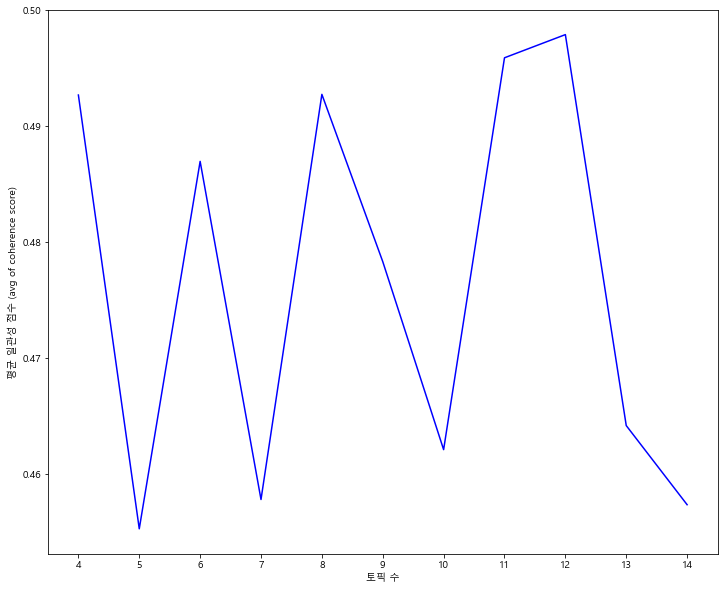

In [22]:
# 그래프 그리기
x = range(start, end, step)

plt.figure(figsize=(12, 10)) 
plt.plot(x, np_cs_avg_list, '-b')
plt.xlabel("토픽 수")
plt.ylabel("평균 일관성 점수 (avg of coherence score)")
plt.xticks(x)

## 위에서 구한 일관성 점수 기준으로 최적 토픽 모델 결정

In [23]:
dtm_model = dtm_model[np.argmax(np_cs_avg_list)]
len(dtm_model.print_topics())

NameError: name 'np_cs_avg_list' is not defined

## DTM 결과보기

In [25]:
# 고정된 시간 내에서 전체 토픽보기
pprint(dtm_model.print_topics(time=1, top_terms=20))

[[('최고', 0.07001649798931316),
  ('포인트', 0.053602048229677804),
  ('적립', 0.0521056152605506),
  ('프로', 0.051559040845456),
  ('답변', 0.04651368737304476),
  ('다운', 0.03922151463627158),
  ('회사', 0.026164036893195387),
  ('현재', 0.025317303405731885),
  ('에러', 0.023131949917973706),
  ('문의', 0.022628526674195067),
  ('사용', 0.021568832197757022),
  ('예전', 0.020226310080671047),
  ('버전', 0.019535381107736394),
  ('가게', 0.01751299756545957),
  ('지금', 0.015725736780723452),
  ('이제', 0.015361431996847084),
  ('감사', 0.01507301379432452),
  ('대기', 0.014921422836049624),
  ('세상', 0.014338640663679427),
  ('대박', 0.013808324418750862)],
 [('가맹', 0.1120175720002429),
  ('결제', 0.05867388394132755),
  ('확인', 0.05196633086634966),
  ('알림', 0.049918155758229346),
  ('잔액', 0.043911515516504636),
  ('찾기', 0.04219288161486457),
  ('검색', 0.03786719217745438),
  ('개선', 0.027582749040177743),
  ('기능', 0.02436930662288557),
  ('충전', 0.021857605917944976),
  ('화면', 0.020607776059782514),
  ('설정', 0.019379978487

In [26]:
# 고정된 토픽 내에서 전체 시간 변화 보기
dtm_model.print_topic_times(topic=0, top_terms=20)

[[('최고', 0.07062006250042156),
  ('포인트', 0.053411398187502734),
  ('적립', 0.05200975139860206),
  ('프로', 0.05162119458100169),
  ('답변', 0.04570841865409775),
  ('다운', 0.04057125755208223),
  ('회사', 0.025873993886910654),
  ('현재', 0.025282645222782948),
  ('에러', 0.02320360521152509),
  ('문의', 0.022523918860693073),
  ('사용', 0.0215423669056965),
  ('예전', 0.01984606429409958),
  ('버전', 0.019496561255528927),
  ('가게', 0.017637146243612914),
  ('지금', 0.015636670151540997),
  ('이제', 0.015298179487032446),
  ('감사', 0.015063061645856742),
  ('대기', 0.014875866807749247),
  ('세상', 0.014389541174000113),
  ('대박', 0.01387743004762505)],
 [('최고', 0.07001649798931316),
  ('포인트', 0.053602048229677804),
  ('적립', 0.0521056152605506),
  ('프로', 0.051559040845456),
  ('답변', 0.04651368737304476),
  ('다운', 0.03922151463627158),
  ('회사', 0.026164036893195387),
  ('현재', 0.025317303405731885),
  ('에러', 0.023131949917973706),
  ('문의', 0.022628526674195067),
  ('사용', 0.021568832197757022),
  ('예전', 0.020226310080

In [14]:
word_dict = {};

for i in range(NUM_TOPICS):

    words = dtm_model.print_topic(i)

    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]

pd.DataFrame(word_dict)

NameError: name 'NUM_TOPICS' is not defined

## 6. 문서별 토픽 비중 구하기
> 1) 토픽 비중 계산을 위한 데이터 전처리

> 2) OOM 문제 해결을 위한 샘플링

> 3) DataFrame으로 만들어 excel 파일로 저장

In [27]:
doc_time = []

for doc_id in range(len(tokenized_data)):
    if doc_id < time_slice[0]:
        doc_time.append(0)
    else:
        doc_time.append(1)
    
        
print(len(doc_time))

2266


In [28]:
# time_slot 별로 900개씩만 뽑기.
sample_idx1 = np.random.randint(0, time_slice[0], size=900)
sample_idx2 = np.random.randint(time_slice[0], time_slice[0] + time_slice[1], size=900)



[ 952  113  939 1235 1047  865   42  108  916 1191]
[1597 1396 1338 1856 1355 2255 1406 1806 2194 1390]


In [29]:
# OOM(Out-of-Memory) 문제로 인해 1000개씩 샘플링 하여 실행.

processing_docs = []
processing_time = []

sample_indices = np.concatenate((sample_idx1, sample_idx2))

for idx in sample_indices:
    processing_docs.append(tokenized_data[idx])
    processing_time.append(doc_time[idx])
    

1800
1800


In [32]:
doc_dist = []

for doc_id in sample_indices:
    doc_dist.append(dtm_model.doc_topics(doc_id))

In [33]:
doc_dist = np.array(doc_dist)
doc_topic_dist = doc_dist.T
doc_topic_dist.shape

(9, 1800)

In [34]:
NUM_TOPICS = dtm_model.num_topics

for i in range(NUM_TOPICS):
    print("%f" % doc_dist[0][i], end=", ")

print()

for i in range(NUM_TOPICS):
    print("%f" % doc_topic_dist[i][0], end=", ")

0.001642, 0.001642, 0.001642, 0.001642, 0.001642, 0.001642, 0.581646, 0.406859, 0.001642, 
0.001642, 0.001642, 0.001642, 0.001642, 0.001642, 0.001642, 0.581646, 0.406859, 0.001642, 

In [35]:
doc_topic_dist[0].shape

(1800,)

In [37]:
dtm_df = pd.DataFrame({"Time" : processing_time, "Topic0" : doc_topic_dist[0], "Topic1" : doc_topic_dist[1],
                      "Topic2" : doc_topic_dist[2], "Topic3" : doc_topic_dist[3], "Topic4" : doc_topic_dist[4]
                    , "Topic5" : doc_topic_dist[5], "Topic6" : doc_topic_dist[6], "Topic7" : doc_topic_dist[7],
                       "Topic8" : doc_topic_dist[8]
                      })

print(dtm_df.head())
dtm_df.to_excel("dong100_dtm_12topic_dist.xlsx")

   Time    Topic0    Topic1    Topic2    Topic3    Topic4    Topic5    Topic6  \
0     0  0.001642  0.001642  0.001642  0.001642  0.001642  0.001642  0.581646   
1     0  0.001100  0.526072  0.001100  0.110039  0.087428  0.001100  0.001100   
2     0  0.004785  0.004785  0.004785  0.004785  0.004785  0.004785  0.004785   
3     0  0.004785  0.004785  0.004785  0.004785  0.482376  0.004785  0.004785   
4     0  0.000827  0.000827  0.000827  0.000827  0.162540  0.000827  0.000827   

     Topic7    Topic8  
0  0.406859  0.001642  
1  0.270959  0.001100  
2  0.961722  0.004785  
3  0.004785  0.484131  
4  0.421942  0.410556  


## 7. 시간대별 토픽비중 변화 추이
> 1) 토픽 비중 변화를 보기 위한 데이터 전처리

> 2) 시간대별 토픽 비중 평균 계산

In [38]:
# groupby 오브젝트 생성하기
doctopic_timeslot = dtm_df.groupby('Time')
doctopic_timeslot.groups

{0: Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
             ...
             890, 891, 892, 893, 894, 895, 896, 897, 898, 899],
            dtype='int64', length=900),
 1: Int64Index([ 900,  901,  902,  903,  904,  905,  906,  907,  908,  909,
             ...
             1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799],
            dtype='int64', length=900)}

In [39]:
# mean() 함수 이용해서 Topic0~TopicN까지의 모든 열 평균 구하기
timeslot_avg = doctopic_timeslot.mean()
timeslot_avg = timeslot_avg.reset_index()   # index 리셋하기
timeslot_avg

,Time,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8
0,0,0.099541,0.067436,0.062597,0.050793,0.271521,0.096385,0.056102,0.183136,0.112490
1,1,0.060739,0.126155,0.205124,0.131779,0.072033,0.104924,0.069071,0.152031,0.078145


In [40]:
# 시기별 모든 토픽 값들의 합은 1이다.
timeslot_avg.sum(axis=1)

0    1.0
1    2.0
dtype: float64

## 8. 6번7번 결과를 그래프로

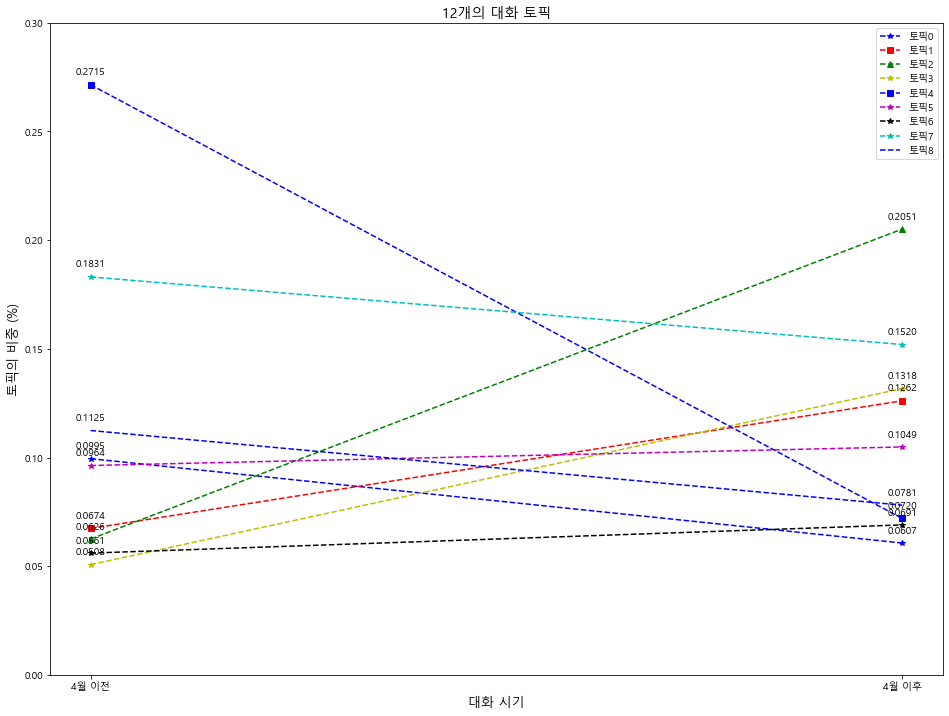

In [82]:
# figure 하나당 4개씩 그래프 그리기
from matplotlib import pyplot as plt
plt.figure(figsize=(16, 12)) 
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic0'], 'b*--', label='토픽0')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic1'], 'rs--', label='토픽1')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic2'], 'g^--', label='토픽2')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic3'], 'y*--', label='토픽3')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic4'], 'bs--', label='토픽4')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic5'], 'm*--', label='토픽5')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic6'], 'k*--', label='토픽6')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic7'], 'c*--', label='토픽7')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic8'], 'b--', label='토픽8')

#그래프에서 값 표시하는 annotate 방법 찾기
for topic_id in ['Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8']:
    for x, y in zip(range(len(time_slice)), timeslot_avg[topic_id]):
        plt.annotate("%.4f"%y, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("12개의 대화 토픽", fontsize=14)
plt.xlabel("대화 시기", fontsize=13)
plt.ylabel("토픽의 비중 (%)", fontsize=13)
plt.xticks(timeslot_avg['Time'], ['4월 이전','4월 이후'])
plt.ylim([0.00, 0.3])
plt.legend(loc="best")
plt.savefig("dong100_topic_distribution_graph.png")
plt.show()

In [59]:
from collections import defaultdict
# 단어의 확률 변화를 보고 싶은 topic 번호 
topic_id = 4
# 해당 토픽에서 포함할 단어목록 결정
topic_info = dtm_model.print_topic_times(topic=topic_id, top_terms=10)
topic_dict = defaultdict(list)

#time별 특정 topic(topic_id)의 단어별 확률값.
for dist_inTime in topic_info:
    #time별로 단어와 확률값 저장.
    for word, prob in dist_inTime:
        topic_dict[word].append(prob)

In [80]:
print(topic_dict)

defaultdict(<class 'list'>, {'오류': [0.04671879723063112, 0.04667621678231401], '접속': [0.041795583798141946, 0.04157349845065354], '인증': [0.0346345163586488, 0.034542669403132414], '실행': [0.03221799222335726, 0.032079970223627546], '연결': [0.030603231897875824, 0.031507987730594045], '네트워크': [0.02774968606663024, 0.027582813625545977], '충전': [0.026832876228462244, 0.02681113246669785], '다시': [0.02564248801880364, 0.02559432180647407], '계좌': [0.024370127794495523, 0.02460947539459961], '계속': [0.024354228040320957, 0.02431342424938992]})


In [83]:
from collections import defaultdict
# 단어의 확률 변화를 보고 싶은 topic 번호 
topic_id = 2
# 해당 토픽에서 포함할 단어목록 결정
topic_info = dtm_model.print_topic_times(topic=topic_id, top_terms=10)
topic_dict = defaultdict(list)

#time별 특정 topic(topic_id)의 단어별 확률값.
for dist_inTime in topic_info:
    #time별로 단어와 확률값 저장.
    for word, prob in dist_inTime:
        topic_dict[word].append(prob)

In [84]:
print(topic_dict)

defaultdict(<class 'list'>, {'카드': [0.20755580956045394, 0.20679005713382204], '발급': [0.10116974612705028, 0.10091969349549905], '기존': [0.06981979629428169, 0.07430408385185028], '신청': [0.03826362427688667, 0.03800335146819772], '사용': [0.03498957824698463, 0.03499348775803182], '신규': [0.03308866621720359, 0.03319709237876355], '선불카드': [0.018760258850626172, 0.018840777331045205], '무조건': [0.0151459072015973, 0.015069930304065008], '취소': [0.013539268839719388, 0.01348482139952493], '재발': [0.011546031199129276], '연동': [0.011577968988921558]})


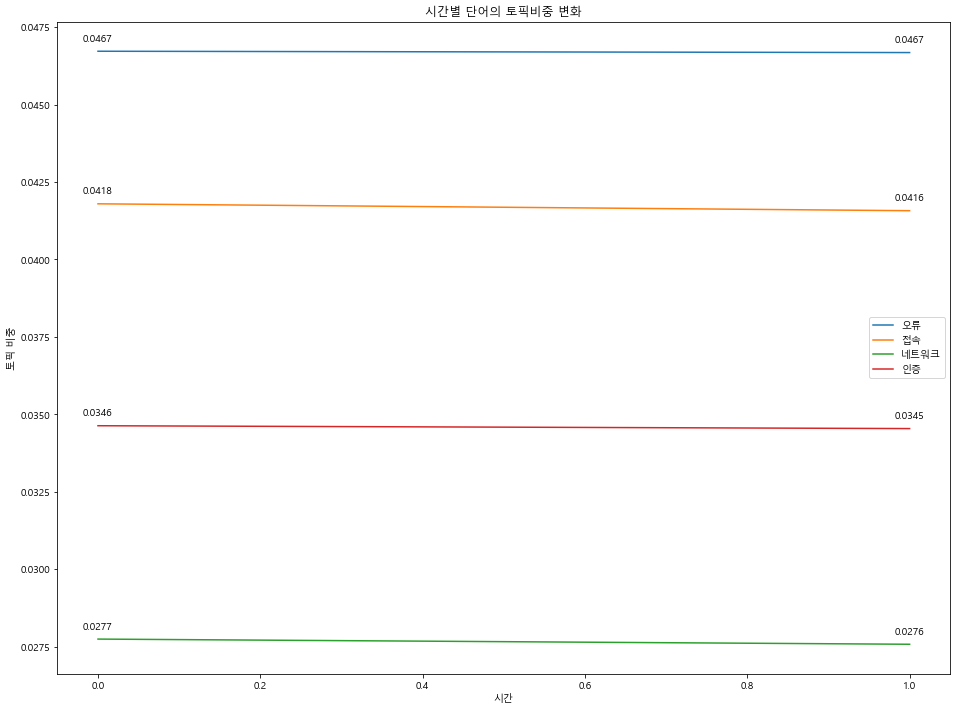

In [81]:
#확률값 추이를 보고싶은 단어 목록
keywords = ["오류","접속","네트워크","인증"]

# time_slot
t = [i for i in range(len(time_slice))]

plt.figure(figsize=(16, 12))
for keyword in keywords:
    plt.plot(t, topic_dict[keyword], label=keyword)
    
    for x, y in zip(t, topic_dict[keyword]):
         plt.annotate("%.4f"%y, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("시간별 단어의 토픽비중 변화")
plt.xlabel("시간")
plt.ylabel("토픽 비중")
plt.legend(loc='best')
plt.savefig("kakao_keywords_distribution_overtime_graph.png")
plt.show()